<a href="https://colab.research.google.com/github/GawainGan/Causal-Inference/blob/main/Causal%20Inference%20and%20Discovery%20in%20Python/Chap_9_Part_I_Matching%2CPropensity_Scores_and_IPW_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Package

In [ ]:
!pip install react

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for react: filename=react-4.3.0-py3-none-any.whl size=4839 sha256=27eb8fc1482eac63aa3e1048e630b71d80092a0bc9023f9d7726feaedb2a38ec
  Stored in directory: /root/.cache/pip/wheels/7c/95/2c/984564ad0d89a8dfbb16952e144462b0c1268e2ecf6d4f9efc
  Created wheel for optional-django: filename=optional_django-0.3.0-py3-none-any.whl size=10538 sha256=76edc6db85725cca9f884d3d5919378d090b437c200f15b71ec49307c68603d4
  Stored in directory: /root/.cache/pip/wheels/7b/e2/96/a5db3b3a3f504fd0b8871aba165002426d293ecde2391ec60a
Successfully built react optional-django


In [ ]:
!pip install dowhy==0.8 # fix the error: https://github.com/py-why/dowhy/issues/1028
!pip install econml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.3/287.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 7.3 MB/s eta 0:00:00


In [ ]:
import sys
print(sys.version)

3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]


In [ ]:
from copy import deepcopy

import numpy as np
import pandas as pd
from scipy import stats

from sklearn.metrics import mean_absolute_percentage_error

import dowhy
from dowhy import CausalModel

from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from lightgbm import LGBMRegressor, LGBMClassifier

import networkx as nx

from tqdm import tqdm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import graphviz

import warnings
warnings.filterwarnings('ignore')

In [ ]:
dowhy.__version__

COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

# Part 1 - Matching


Data Description:

  - A binary indicator of a training program participation
  - The subject’s age
  - The subject’s yearly earnings 18 months after the training took place (in United States Dollar (USD))

In [ ]:
df_path = '/content/drive/MyDrive/Colab Notebooks/Causal Inference and Discovery in Python/data/ml_earnings.csv'

In [ ]:
df = pd.read_csv(df_path)
df.head()

,age,took_a_course,earnings
0,19,False,110579.0
1,28,False,142577.0
2,22,True,130520.0
3,25,True,142687.0
4,24,False,127832.0


In [ ]:
df.groupby(['age', 'took_a_course']).mean()

earnings
age took_a_course               
19  False          111110.875000
    True           123488.000000
20  False          115227.142857
    True           125633.285714
21  False          117114.900000
    True           130155.000000
22  False          120226.363636
    True           131437.222222
23  False          124460.900000
    True           134654.333333
24  False          126878.583333
    True           137564.250000
25  False          130812.800000
    True           142715.000000
26  False          134004.250000
    True           144552.800000
27  False          139035.600000
    True           148744.333333
28  False          141580.000000
    True           152485.333333
29  False          145248.600000
    True           152694.000000
30  False          150333.750000
    True           159586.400000
31  False          152532.000000
    True           163592.000000
32  False          157515.200000
    True           169854.000000
33  False          162453.500000
    True           170020.000000
34  False          165694.200000
    True           178922.000000
35  False          172134.250000
    True           180404.500000
36  False          175240.666667
37  False          181514.000000
    True           187627.000000
38  False          185546.333333
39  False          187253.666667
41  False          201729.000000
    True           207676.000000
42  False          203029.000000
    True           214445.000000
43  False          210243.000000
45  True           233035.000000
48  False          239510.000000

In [ ]:
# Compute naive estimate
treatment_avg = df.query('took_a_course==1')['earnings'].mean()
cntrl_avg = df.query('took_a_course==0')['earnings'].mean()

treatment_avg - cntrl_avg

6695.570882852306

## Causal Effect Estimate


### 1. Define the Graph

In [ ]:
# Construct the graph (the graph is constant for all iterations)
nodes = ['took_a_course', 'earnings', 'age']
edges = [
    ('took_a_course', 'earnings'),
    ('age', 'took_a_course'),
    ('age', 'earnings')
]

# Generate the GML graph
gml_string = 'graph [directed 1\n'

for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'

gml_string += ']'

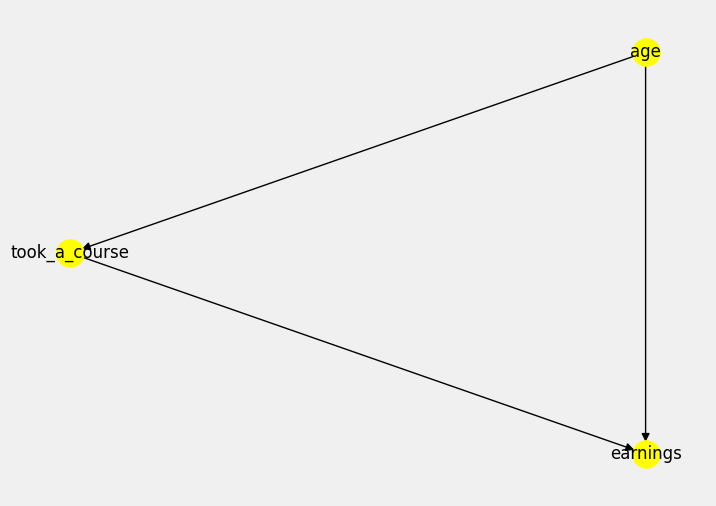

In [ ]:
# Instantiate the CausalModel
model = CausalModel(
    data=df,
    treatment='took_a_course',
    outcome='earnings',
    graph=gml_string
)

model.view_model()

### 2. Get the Estimand(估计量)

In [ ]:
# Get the estimand
estimand = model.identify_effect(proceed_when_unidentifiable=True)

print(estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                         
────────────────(E[earnings|age])
d[took_a_course]                 
Estimand assumption 1, Unconfoundedness: If U→{took_a_course} and U→earnings then P(earnings|took_a_course,age,U) = P(earnings|took_a_course,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### 3. Compute the Causal Efect

In [ ]:
# Get estimate (Matching)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.distance_matching',
    target_units='ate',
    method_params={'distance_metric': 'minkowski', 'p': 2})

estimate.value

distance_matching


10464.5

The true effect size for our data is 10,000 USD

The absolute percentage error is 4.6%, which is a great
improvement over the naïve estimate that resulted in 33% of absolute percentage error!

In [ ]:
refutation = model.refute_estimate(
    estimand=estimand,
    estimate=estimate,
    method_name='random_common_cause',
    show_progress_bar=True
    )

In [ ]:
print(refutation)

Refute: Add a random common cause
Estimated effect:10464.5
New effect:10326.3363
p value:0.48



- The new effect is slightly lower than the estimated one, which means the original model might not cover some potential confounders (原始模型可能忽略了一些潜在的混杂因素，导致轻微高估了Treatment的效应)
- High p value indicates that **the change is not statistically significant**

Outcome:
- P-value说明原始估计有良好的稳健性
- Estimated effect和New effect区别不大，但New effect更小：即估计效应相对接近真实效应
- 添加随机共同原因略微改善了估计，使其更接近真实值，单这种改变在统计上不显著

后续：
- 可能存在其他混杂因子需要探索
- 使用其他refutation测试来进一步验证估计的稳健性

In [ ]:
refutation_subset = model.refute_estimate(
    estimand=estimand,
    estimate=estimate,
    method_name='data_subset_refuter',
    show_progress_bar=True
    )
print(refutation_subset)

Refute: Use a subset of data
Estimated effect:10464.5
New effect:10408.874125
p value:0.8999999999999999



#  Part 2 – propensity scores

## Inverse Probability Weighting (IPW)


### IPW Definition

IPW是一种用于控制混杂因素、估计因果效应的方法。

IPW的核心思想是通过调整样本权重来创建一个"平衡"的数据集,使得处理组和对照组在各个协变量上的分布更加相似。这种方法试图模拟随机对照试验中的随机分配过程

原理:
- 对样本进行加权,提高代表性不足的群体的权重,降低过度代表的群体的权重。
- 使用倾向性得分(接受治疗的概率)的倒数作为权重

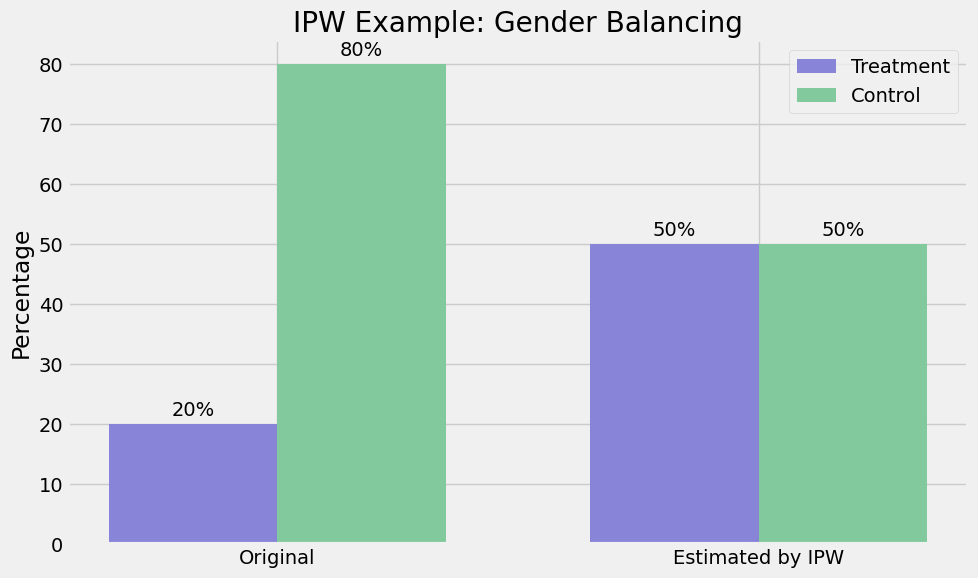

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
categories = ['Original', 'Estimated by IPW']
treatment = [20, 50]
control = [80, 50]

# 创建柱状图
x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, treatment, width, label='Treatment', color='#8884d8')
rects2 = ax.bar(x + width/2, control, width, label='Control', color='#82ca9d')

# 添加一些文本元素
ax.set_ylabel('Percentage')
ax.set_title('IPW Example: Gender Balancing')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# 在柱子上添加数值标签
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show();

假设我们的原始数据中,处理组只有20%是女性,而对照组有80%是女性。通过IPW,我们可以调整权重,使得两组的性别比例都接近50%,从而减少性别作为混杂因素的影响

在实践中,IPW常用于观察性研究,特别是在无法进行随机对照试验的情况下。例如:

- 医疗研究:评估某种药物治疗的效果,但不能随机分配患者到治疗组和对照组。
- 经济学:评估某项政策对经济指标的影响。
- 教育研究:评估某种教学方法对学生成绩的影响。

IPW的优势和局限性:

优势:
- 可以处理高维数据
- 不需要对结果模型进行假设
- 可以估计不同类型的因果效应(如ATE, ATT, ATC)

局限性:
- 对极端倾向性得分敏感
- 如果倾向性模型指定错误,可能导致偏差
- 在小样本情况下可能表现不佳

### 1.Build Model

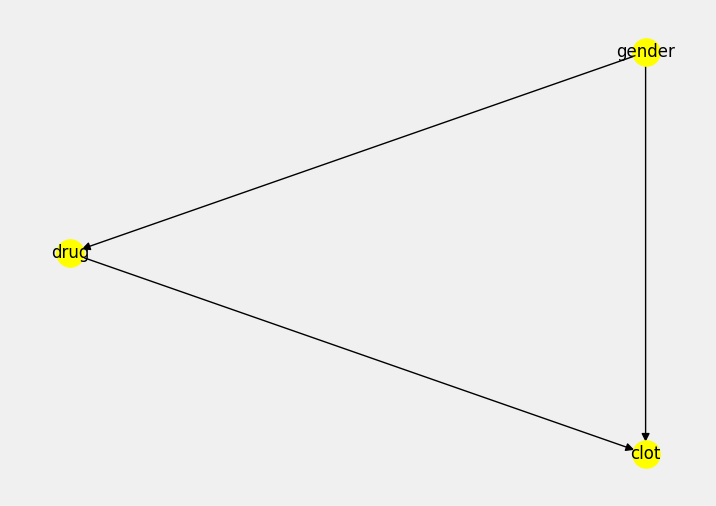

In [ ]:
pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Causal Inference and Discovery in Python/data/ch_01_drug_data.csv')

gender = [1] * (24 + 56 + 17 + 25) + [0] * (3 + 39 + 6 +74)
clot = [1] * 24 + [0] * 56 + [1] * 17 + [0] * 25 + [1] * 3 + [0] * 39 + [1] * 6 + [0] * 74
drug = [0] * (24 + 56) + [1] * (17 + 25) + [0] * 42 + [1] * 80

drug_data = pd.DataFrame(dict(
    gender=gender,
    clot=clot,
    drug=drug
))

# Construct the graph (the graph is constant for all iterations)
nodes_drug = ['drug', 'clot', 'gender']
edges_drug = [
    ('drug', 'clot'),
    ('gender', 'drug'),
    ('gender', 'clot')
]

# Generate the GML graph
gml_string_drug = 'graph [directed 1\n'

for node in nodes_drug:
    gml_string_drug += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges_drug:
    gml_string_drug += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'

gml_string_drug += ']'

# Instantiate the CausalModel
model_drug = CausalModel(
    data=drug_data,
    treatment='drug',
    outcome='clot',
    graph=gml_string_drug
)

model_drug.view_model()

### 2.Estimate Effect (Drug dataset)

In [ ]:
# Identify effect
estimand_drug = model_drug.identify_effect()

# Get estimate (IPW weighting)
estimate_drug = model_drug.estimate_effect(
    identified_estimand=estimand_drug,
    method_name='backdoor.propensity_score_weighting', # 模型假设处理变量和结果变量之间存在可能的混杂因素,而这些因素可以通过观察到的协变量来控制
    target_units='ate'
)

print(estimate_drug.value)

propensity_score_weighting
0.04811580602068774


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### 2.2 Estimate Effect (ml_earnings dataset in part 1)

In [ ]:
# Get estimate (IPW weighting)
estimate_PIW = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.propensity_score_weighting',
    target_units='ate' # 估计平均处理效应。我们关心的是在整个人群中,接受处理与不接受处理之间的平均差异
)

propensity_score_weighting


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
estimate_PIW.value

10313.566831120319

In [ ]:
(estimate.value - 10e3) / 10e3

0.04645

- The true effect size for our data is 10,000 USD
- Distance Matching: 10464.5, the absolute percentage error is 4.6%
- Inverse Probability Weighting: 10313.57, the absolute percentage error is 3.1%



- 效果不错:在给出的结果中中,IPW的误差率(3.1%)比距离匹配法(4.6%)更低。可能是因为IPW能更好地处理样本中的异质性
- 灵活性强:可以与不同的估计技术(如加权最小二乘法)结合使用。

估计的稳健性:

虽然IPW表现良好,但3.1%的误差仍然存在。这可能来自几个源头:
- 倾向性得分模型的潜在误特定化
- 样本中可能存在的极端权重
- 未观察到的混杂因素的影响

实际意义:
估计结果表明,处理(可能是某种干预或政策)平均增加了个人收入约10,313美元。这个效应不仅在统计上显著,而且在经济上也很重要。